In [1]:
import numpy as np
from urllib import request
import gzip
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [3]:
def softmax(x):
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, keepdims = True)
    s = x_exp / x_sum
    return s

In [4]:
def sizes():
    n_x = 784
    n_h = 300
    n_y = 10
    
    return (n_x,n_h,n_y)

In [5]:
def initial_weights(n_x,n_h,n_y):
    W = np.random.randn(n_h,n_x)
    b = np.zeros((n_h,1))
    V = np.random.randn(n_h,n_y) 
    c = np.zeros((1,n_y))
    
    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}
    return parameters

In [6]:
def forward(x, parameters):
    W, b, V, c = parameters['W'], parameters['b'], parameters['V'], parameters['c']
    
    k = np.dot(W,x) + b
    h = sigmoid(k)
    z = np.dot(h.T,V) + c
    y = softmax(z)
    
    cache = {'k':k,
             'h':h,
             'z':z,
             'y':y}
    
    return y, cache

In [7]:
def cross_entropy(y,t):
    logprobs = np.multiply(np.log(y), t) + np.multiply(np.log(1 - y), (1 - t))
    cost = -np.sum(logprobs)/ 10
    
    return cost

In [8]:
def delta_cross_entropy(y,t):
    dloss = y - t
    return dloss

In [9]:
def backward(y,t,x,parameters, cache):
    h,k = cache['h'],cache['k']
    V = parameters['V']
    
    dloss = delta_cross_entropy(y,t)
    dV = np.dot(h, dloss)
    dc = dloss
    dh = np.sum(np.dot(dloss, V.T))
    dk = np.dot(dh,sigmoid(k) * (1-sigmoid(k)))
    dW = np.dot(dk, x.T)
    db = dk
    
    grads = {'dW':dW,
             'db':db,
             'dV':dV,
             'dc':dc}
    
    return grads

In [30]:
def update_parameters(parameters, grads,learning_rate = 0.0001):
    # get weights
    W,b,V,c = parameters['W'], parameters['b'], parameters['V'], parameters['c']
   
    # get gridient
    dW,db,dV,dc = grads['dW'], grads['db'], grads['dV'], grads['dc']
   
    # update weights 
    W = W - learning_rate * dW
    b = b - learning_rate * db
    V = V - learning_rate * dV
    c = c - learning_rate * dc
    
    parameters = {"W": W,
                  "b": b,
                  "V": V,
                  "c": c}
    
    return parameters

In [11]:
def convert_onehot(t):
    t = np.eye(10)[t]
    return t

In [41]:
def nn_model(train_data,true_label,num_iterations,epoch):
    n_x, n_h, n_y = sizes()
    parameters = initial_weights(n_x,n_h,n_y)
    t_oh = convert_onehot(true_label)
    cost_epoch_avg = []
    cost_epoch_std = []
    # gridient descent
    for e in range(epoch):
        print('tarining epoch %i'% e)
        loss = []
        loss_val = []
        for i in range(0, num_iterations):
            x = train_data[i].reshape(784,1)
            y, cache = forward(x, parameters)
            t = t_oh[i].reshape(1,10)
            cost = cross_entropy(y,t)
            grads = backward(y,t,x, parameters,cache)
            parameters = update_parameters(parameters,grads,learning_rate = 0.0001)
            loss.append(cost)
            #print cost
            if i % 5000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
        
        cost_epoch_avg.append(np.mean(loss))
        cost_epoch_std.append(np.std(loss))
         
    return parameters, cost_epoch_avg, cost_epoch_std

In [13]:
def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten:
    :return:
    """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

In [14]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

In [15]:
def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

In [16]:
def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

In [17]:
def init():
    download_mnist()
    save_mnist()

In [18]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [20]:
train_data, test_data, num = load_mnist()

In [42]:
train_data_nol = train_data[0] / 255
test_data_nol = test_data[0] / 255
parameters,cost_epoch_avg, cost_epoch_std = nn_model(train_data_nol,train_data[1],55000,5)

tarining epoch 0
Cost after iteration 0: 2.926560


KeyboardInterrupt: 

In [37]:
cea = cost_epoch_avg
ces = cost_epoch_std
print(cea)
print(ces)

[1.028892738157288, 0.5834220179855385, 0.48118695454546595, 0.44596780371710654, 0.3853830447549302]
[0.8295672658440806, 0.5783703188743582, 0.5232546803928559, 0.5058359154960066, 0.4655909242507477]
[0.660171861387205, 0.47509176410924775, 0.42212903296679544, 0.37404897685678856, 0.3251417099247108]
[0.6005009982136135, 0.5327040800605564, 0.4945063809757671, 0.46041177035046144, 0.42407123370996114]
[1.8306874361824819, 1.5831879017473474, 1.0765437674012541, 1.0236527114182656, 0.22719196100953173]


In [84]:
def predict(parameters, validation,validation_label):
    counts = 0
    t = convert_onehot(validation_label)
    y, cache = forward(validation.T,parameters)
    for i in range(len(y)):
        max_num = np.max(y[i])
        for j in range(len(y[i])):
            if y[i][j] == max_num:
                y[i][j] = 1
            else:
                y[i][j] = 0
    for i in range(len(y)):
        if (y[i] == t[i]).all():
            counts += 1
    
    return counts / 10000

In [85]:
prediction = predict(parameters, test_data_nol, test_data[1])

In [86]:
print(prediction)

0.8987


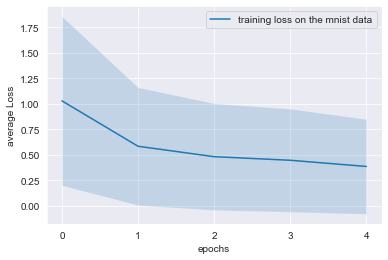

In [40]:
sns.set_style("darkgrid")
x = np.arange(0,5)
my_x_ticks = np.arange(0, 6, 1)
plt.xticks(my_x_ticks)
sns.lineplot(x = x, y = cea,label = 'training loss on the mnist data')
#sns.lineplot(x = x, y = ceav, color = 'red',label = 'validataion loss on the mnist data')
plt.fill_between(x = x, y1 = [(cea[i]-ces[i]) for i in range(len(cea))], y2 = [(cea[i]+ces[i]) for i in range(len(cea))],alpha = 0.2)
#plt.fill_between(x = x, y1 = [(ceav[i]-cesv[i]) for i in range(len(ceav))], y2 = [(ceav[i]+cesv[i]) for i in range(len(ceav))],alpha = 0.2)
plt.xlabel('epochs')
plt.ylabel('average Loss')
plt.legend()
plt.savefig(r'C:\Users\WXK\Desktop\Deep learning\std final training loss on the mnist data_0.0001.png')